In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../2330.TW_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-03,103.0,103.0,102.0,102.5,75.244667,38599000
2014-01-06,102.0,103.0,102.0,102.5,75.244667,23706000
2014-01-07,102.5,103.0,102.0,102.0,74.877609,15836000
2014-01-08,103.0,104.5,102.5,104.0,76.345802,30218000
2014-01-09,102.5,103.0,100.5,101.0,74.143509,63998000
...,...,...,...,...,...,...
2023-12-25,582.0,585.0,580.0,581.0,573.515503,9548143
2023-12-26,583.0,586.0,582.0,586.0,578.451111,16094308
2023-12-27,587.0,592.0,586.0,592.0,584.373840,33401336


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 10 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

(2439, 4)
torch.Size([1931, 10, 4])


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers)
        
    def forward(self, x):
        # x: input batch data, size: [input_seq_len, batch_size, feature_size]
        output, (hidden, cell) = self.lstm(x)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(output_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        """
        x size = [batch_size, feature_size]
        --> x only has two dimensions since the input is batch of last coordinate of observed trajectory
        so the sequence length has been removed.
        """
        # add sequence dimension to x, to allow use of nn.LSTM
        x = x.unsqueeze(0)  # -->[1, batch_size, feature_size]
        
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.linear(output)

        return prediction, hidden, cell    

In [5]:
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, teacher_forcing_ratio=0.5):
        x = x.permute(1,0,2) #我們的 dataloader是 [batch, seq,dim]
        y = y.permute(1,0,2) #但為了方便操作LSTM，直接把它擺成[seq,batch,dim]，output再把它擺回來
        """
        x = [input_seq_len, batch_size, feature_size]
        y = [target_seq_len, batch_size, feature_size]
        """
        batch_size = x.shape[1]
        target_len = y.shape[0]
        
        # tensor to store decoder outputs of each time step
        outputs = torch.zeros(y.shape).to(self.device) 
        
        hidden, cell = self.encoder(x)
        decoder_input = x[-1, :, :] # first input to decoder is last of x
        
        for i in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            # place predictions in a tensor holding predictions for each time step
            outputs[i] = torch.squeeze(output,0)
            
            teacher_forcing = random.random() < teacher_forcing_ratio
            # output is the same shape as decorder input-->[batch_size, feature_size]
            # so we use output directly as input or use true lable depending on teacher_forcing flag
            decoder_input = y[i] if teacher_forcing else torch.squeeze(output,0)
        
        return outputs.permute(1,0,2)

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
encoder = Encoder(input_size=4, hidden_size=128).to(device)
decoder = Decoder(output_size=4, hidden_size=128).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [12]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "seq_lstm_10.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.5)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model, best_model_path) 
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Model saved with val_loss: 0.0099
Epoch [1/100], Train Loss: 0.0047, Val Loss: 0.0099
Epoch [2/100], Train Loss: 0.0464, Val Loss: 0.0106
Epoch [3/100], Train Loss: 0.0757, Val Loss: 0.0162
Epoch [4/100], Train Loss: 0.0624, Val Loss: 0.0613
Epoch [5/100], Train Loss: 0.0645, Val Loss: 0.0426
Epoch [6/100], Train Loss: 0.0720, Val Loss: 0.0422
Epoch [7/100], Train Loss: 0.0198, Val Loss: 0.0157
Model saved with val_loss: 0.0019
Epoch [8/100], Train Loss: 0.0031, Val Loss: 0.0019
Epoch [9/100], Train Loss: 0.0013, Val Loss: 0.0040
Epoch [10/100], Train Loss: 0.0011, Val Loss: 0.0051
Epoch [11/100], Train Loss: 0.0013, Val Loss: 0.0038
Epoch [12/100], Train Loss: 0.0016, Val Loss: 0.0058
Epoch [13/100], Train Loss: 0.0023, Val Loss: 0.0169
Epoch [14/100], Train Loss: 0.0023, Val Loss: 0.0031
Epoch [15/100], Train Loss: 0.0056, Val Loss: 0.0025
Epoch [16/100], Train Loss: 0.0049, Val Loss: 0.0184
Epoch [17/100], Train Loss: 0.0055, Val Loss: 0.0022
Epoch [18/100], Train Loss: 0.0100, Val 

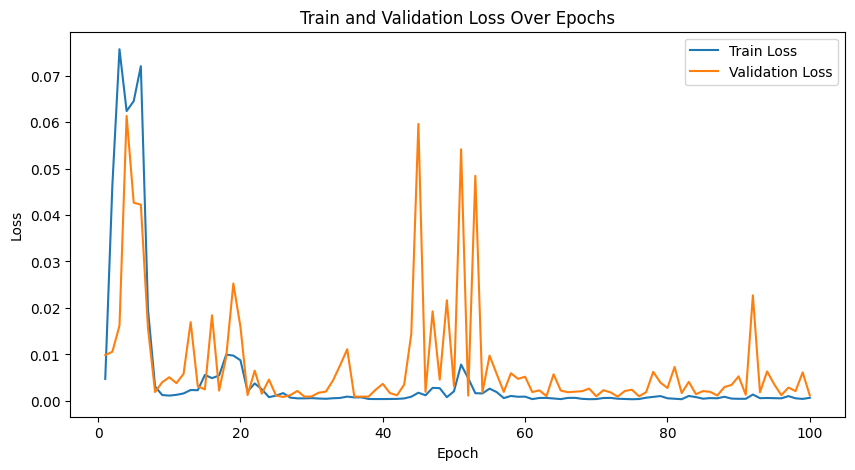

In [13]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

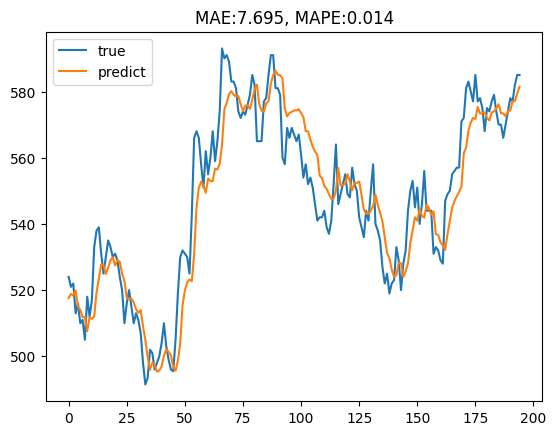

In [14]:
import matplotlib.pyplot as plt
close_price_true = []
close_price_pred = []
model = torch.load('seq_lstm_10.pth')
model.to(device)

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])

In [15]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
print("mape: ", mape)
print("mae: ", mae)

(195, 10)
(195, 10)
mape:  0.026634613419643415
mae:  14.43567883288249


In [9]:
ma10_f=[]
true=[]
pred=[]
for i in range(0,len(close_price_pred)):
    true.append(round(close_price_true[i][0]))
    ma10_f.append(np.mean(close_price_pred[i]))
    pred.append(close_price_pred[i][0])

newdf = pd.DataFrame({'True':true, 'Pred':pred, 'MA10_F':ma10_f})
newdf

,True,Pred,MA10_F
0,524,517.216045,519.692594
1,521,519.910537,521.831984
2,522,519.789782,522.195177
3,513,521.493200,524.006070
4,516,516.392076,520.521385
...,...,...,...
190,578,573.261392,571.890175
191,577,576.542369,573.483036
192,582,575.509076,573.515870
193,585,580.256440,575.189967


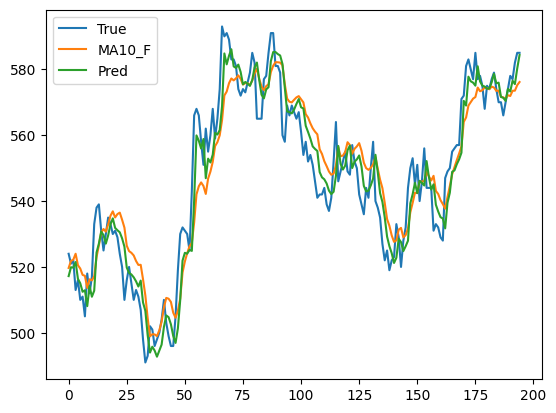

In [10]:
plt.plot(newdf['True'])
plt.plot(newdf['MA10_F'])
plt.plot(newdf['Pred'])
plt.legend(['True','MA10_F','Pred'])

In [11]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, ma10_f, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (ma10_f[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (ma10_f[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['MA10_F'], cash, position, buy_flag)

1 1000000 0
2 479000 1
3 479000 0
4 479000 0
5 479000 0
6 479000 0
7 479000 0
8 479000 0
9 997000 -1
10 485000 1
11 485000 0
12 1018000 -1
13 1018000 0
14 1018000 0
15 487000 1
16 487000 0
17 487000 0
18 487000 0
19 487000 0
20 487000 0
21 487000 0
22 487000 0
23 487000 0
24 487000 0
25 487000 0
26 487000 0
27 487000 0
28 487000 0
29 487000 0
30 487000 0
31 487000 0
32 487000 0
33 487000 0
34 487000 0
35 487000 0
36 989000 -1
37 989000 0
38 493000 1
39 493000 0
40 493000 0
41 493000 0
42 493000 0
43 493000 0
44 493000 0
45 493000 0
46 493000 0
47 493000 0
48 1012000 -1
49 1012000 0
50 1012000 0
51 1012000 0
52 1012000 0
53 487000 1
54 1030000 -1
55 1030000 0
56 1030000 0
57 1030000 0
58 1030000 0
59 1030000 0
60 1030000 0
61 1030000 0
62 1030000 0
63 1030000 0
64 1030000 0
65 1030000 0
66 1030000 0
67 1030000 0
68 1030000 0
69 1030000 0
70 1030000 0
71 1030000 0
72 1030000 0
73 1030000 0
74 456000 1
75 456000 0
76 456000 0
77 456000 0
78 1032000 -1
79 1032000 0
80 1032000 0
81 1032000 

In [12]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, pred, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (pred[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (pred[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['Pred'], cash, position, buy_flag)

1 1000000 0
2 1000000 0
3 1000000 0
4 487000 1
5 1003000 -1
6 493000 1
7 493000 0
8 493000 0
9 1011000 -1
10 1011000 0
11 1011000 0
12 1011000 0
13 1011000 0
14 1011000 0
15 1011000 0
16 486000 1
17 1016000 -1
18 1016000 0
19 483000 1
20 483000 0
21 483000 0
22 483000 0
23 483000 0
24 483000 0
25 483000 0
26 483000 0
27 1003000 -1
28 488000 1
29 488000 0
30 488000 0
31 488000 0
32 488000 0
33 488000 0
34 488000 0
35 488000 0
36 990000 -1
37 990000 0
38 990000 0
39 990000 0
40 990000 0
41 990000 0
42 990000 0
43 487000 1
44 487000 0
45 487000 0
46 487000 0
47 992000 -1
48 992000 0
49 992000 0
50 992000 0
51 992000 0
52 992000 0
53 992000 0
54 992000 0
55 992000 0
56 992000 0
57 992000 0
58 434000 1
59 985000 -1
60 985000 0
61 985000 0
62 985000 0
63 985000 0
64 426000 1
65 991000 -1
66 991000 0
67 991000 0
68 991000 0
69 991000 0
70 991000 0
71 991000 0
72 991000 0
73 410000 1
74 410000 0
75 410000 0
76 410000 0
77 410000 0
78 986000 -1
79 986000 0
80 986000 0
81 404000 1
82 404000 0
83

In [35]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x, y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    
    # 取第十天的真實值和預測值
    y_tenth_day = torch.squeeze(y)[9]  # 第 10 天對應索引為 9
    pred_tenth_day = torch.squeeze(pred.detach().cpu())[9]
    
    # 反轉換
    true_tenth_day = scaler.inverse_transform(y_tenth_day.unsqueeze(0))[:, dim]
    pred_tenth_day = scaler.inverse_transform(pred_tenth_day.unsqueeze(0))[:, dim]
    
    # 儲存第十天的值
    close_price_true.append(true_tenth_day)
    close_price_pred.append(pred_tenth_day)

# 將結果轉換為 NumPy 陣列
close_price_true = np.array(close_price_true).squeeze()
close_price_pred = np.array(close_price_pred).squeeze()

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)

# 計算 MAE 和 MAPE
mape = np.mean(np.abs(close_price_true - close_price_pred) / close_price_true)
mae = np.mean(np.abs(close_price_true - close_price_pred))

print("第十天的 mape: ", mape)
print("第十天的 mae: ", mae)


(195,)
(195,)
第十天的 mape:  0.032063441706474516
第十天的 mae:  17.57872759531706


In [9]:
import csv

with open('ex2output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(close_price_pred)):
    rows[i].append(close_price_pred[i][0].item())

# 寫回檔案
with open('ex2output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

